## Conclusiones

* Fue llevado a cabo un proceso de limpieza, transformación y predicción de los datos de inmuebles en Colombia entre 2020 y 2021. 

* El dataset cuenta con 1 millón de registros y a partir de la información del área, ubicación, habitacione, baños, entre otras características, fueron usados modelos de Machine Learning como Linear Regression, Decission Tree, Random Forest y otros para predecir el precio de cada inmueble. 

* El **modelo que mejor se ajustó fue Random Forest** al cual se le hizo un ajuste de hiperparámetros mediante GridSearch. El R2 del modelo validado fue 0.44, es decir, **el modelo puede explicar el 44% de la variabilidad de los datos**.

## Librerías

In [1]:
import pandas as pd; import matplotlib.pyplot as plt; import numpy as np; import seaborn as sns

## Lectura y preprocesamiento de los datos

In [2]:
df = pd.read_csv('co_properties.csv')

### Estilos para los gráficos

In [3]:
##Estilos
#-------------------------Estilos para los gráficos
import matplotlib as mpl
plt.style.use("fivethirtyeight") 
mpl.rcParams["font.size"]=10.5 
mpl.rcParams["legend.fontsize"]=14
mpl.rcParams["font.family"]="serif"
mpl.rcParams["font.weight"]="bold"
mpl.rcParams["legend.fancybox"]=True
mpl.rcParams["xtick.labelsize"]=10
mpl.rcParams["ytick.labelsize"]=16
mpl.rcParams["figure.titleweight"]="bold"
mpl.rcParams["axes.labelweight"]="bold"
mpl.rcParams["figure.facecolor"]="white"
mpl.rcParams["axes.facecolor"]="white"
mpl.rcParams["axes.edgecolor"]="0.2"
mpl.rcParams["axes.linewidth"]=1
mpl.rcParams["axes.titleweight"]="bold"
mpl.rcParams["axes.labelsize"]=16
mpl.rcParams["figure.titlesize"]=20
mpl.rcParams["axes.titlesize"]=25
mpl.rcParams["figure.labelsize"]=16
mpl.rcParams["figure.labelweight"]="bold"
mpl.rcParams['axes.grid']=False

In [4]:
##Tamaño del dataset y datos faltantes

print(f'Dataset size: {df.shape[0]} rows and {df.shape[1]} columns\n')

def missing_values(df):
    missing_percentage = {}
    for i,col in enumerate(df):
        missing_percentage[col] = df[col].isna().sum()/df.shape[0]*100
    
    over_30_percent = {}
    for key, value in missing_percentage.items():
        if value>30:
            over_30_percent[key] = value
    print(f'There are {len(over_30_percent)} columns with over 30% of missing values'.center(70,'-'))
    
    for key,value in missing_percentage.items():
        print(f'{key} = {value:.2f}%')
    return over_30_percent
delete_columns = missing_values(df).keys()

Dataset size: 1000000 rows and 25 columns

---------There are 8 columns with over 30% of missing values----------
id = 0.00%
ad_type = 0.00%
start_date = 0.00%
end_date = 0.00%
created_on = 0.00%
lat = 25.97%
lon = 25.97%
l1 = 0.00%
l2 = 0.00%
l3 = 6.28%
l4 = 72.60%
l5 = 84.09%
l6 = 94.53%
rooms = 82.79%
bedrooms = 62.40%
bathrooms = 20.05%
surface_total = 95.88%
surface_covered = 94.01%
price = 0.05%
currency = 0.06%
price_period = 87.88%
title = 0.00%
description = 0.06%
property_type = 0.00%
operation_type = 0.00%


#### Análisis iniciales
1. El dataset tiene 25 columnas. 
2. Hay 8 columnas con más del 30% de datos faltantes. Estas serán descartadas del análisis general pero serán trabajadas en el análisis específico.
3. La columna created_on tiene los mismos datos de la columna start_date por lo cual será descartada.
4. La columna id es irrelevante para el análisis.
5. Las columnas title y description generan conflicto puesto que son strings sin un formato específico de escritura por lo cual serán descartadas.
6. La columna ad_type, currency y l1 solo tienen un valor por lo cual serán descartadas.
7. La columna end_date tiene fechas más allá de 2024 lo cual no tiene sentido. Serán reemplazados valores más allá de 2024 con la fecha máxima
8. Los valores faltantes de las demás columnas serán llenados con la moda en caso de ser categórica, o con el promedio en caso de ser numérica.

In [5]:
df_gen = df.drop(columns=delete_columns).drop(columns=['id','created_on','title','description','ad_type','l1','currency'])

df_gen = df_gen.loc[df_gen['operation_type']!='Arriendo temporal']

new_names = {'l2':'State','l3':'City'}

df_gen = df_gen.rename(columns=new_names)

filling_dictionary = {'bathrooms':df_gen['bathrooms'].mean(),
                      'City':df_gen['City'].mode()[0],
                      'price':df_gen['price'].mean(),}

df_gen = df_gen.fillna(filling_dictionary)

##Conversión de tipos de datos

df_gen['start_date'] = pd.to_datetime(df_gen['start_date'])
df_gen.loc[df_gen['end_date']>'2021-10-18','end_date']='2021-10-18'
df_gen['end_date'] = pd.to_datetime(df_gen['end_date'])

df_gen['price'] = df_gen['price']/1000000
df_gen['price'] = df_gen['price'].astype(np.float64)
df_gen['bathrooms'] = df_gen['bathrooms'].astype(np.int32)

In [6]:
##Verificar valores atípicos. Aquellos valores por encima del rango intercuartílico (IQR) serán reemplazados por el valor máximo del rango IQR.
##Aquellos valores por debajo del IQR serán reemplazados por el valor mínimo del rango.


q1_sell = df_gen.loc[df_gen['operation_type']=='Venta']['price'].quantile(0.25)
q3_sell = df_gen.loc[df_gen['operation_type']=='Venta']['price'].quantile(0.75)
iqr_sell = q3_sell - q1_sell

q1_rent = df_gen.loc[df_gen['operation_type']=='Arriendo']['price'].quantile(0.25)
q3_rent = df_gen.loc[df_gen['operation_type']=='Arriendo']['price'].quantile(0.75)
iqr_rent = q3_rent - q1_rent

df_gen.loc[(df_gen['operation_type']=='Venta')&(df_gen['price']>q3_sell + 1.5*iqr_sell),'price'] = iqr_sell*1.5
df_gen.loc[(df_gen['operation_type']=='Arriendo')&(df_gen['price']>q3_rent + 1.5*iqr_rent),'price'] = iqr_rent*1.5

df_gen.loc[(df_gen['operation_type']=='Venta')&(df_gen['price']<q1_sell - 1.5*iqr_sell),'price'] = iqr_sell*1.5
df_gen.loc[(df_gen['operation_type']=='Arriendo')&(df_gen['price']<q1_rent - 1.5*iqr_rent),'price'] = iqr_rent*1.5


In [7]:
##Cálculo de columnas derivadas

##Cantidad de días hasta que la casa se vendió

df_gen['sold_after'] = (df_gen['end_date'] - df_gen['start_date']).dt.days

##Reclasificación de las columnas que tienen demasiados valores diferentes.

too_much_uniques = ['City','State','property_type']
def reclass_unique_values(too_much_uniques,df=df_gen.copy(),head=5):
    
    for i in range(len(too_much_uniques)):
        main = df[too_much_uniques[i]].value_counts(normalize=True,sort=True).head(head).index
        df['Main_'+too_much_uniques[i]] = False
        df.loc[df[too_much_uniques[i]].isin(main),'Main_'+too_much_uniques[i]]=True
        df.loc[df['Main_'+too_much_uniques[i]]==False,too_much_uniques[i]]='Others'
        df = df.drop(columns='Main_'+too_much_uniques[i])
    return df

df_gen2 = reclass_unique_values(too_much_uniques)
df_gen2['property_type'] = df_gen2['property_type'].str.replace('Otro','Others')

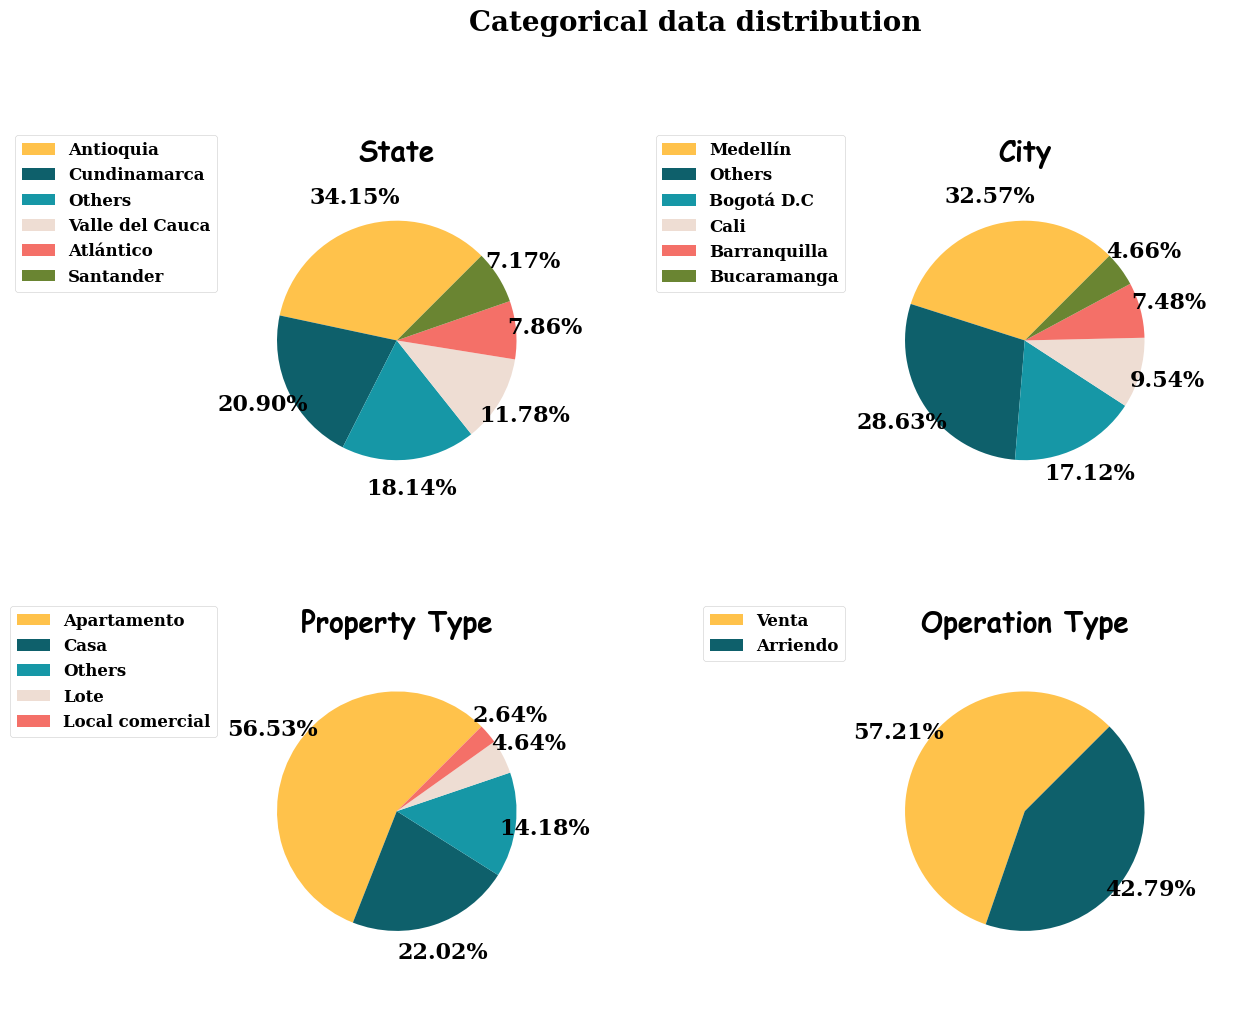

In [8]:
##Distribución de los datos categóricos

cat = df_gen2.select_dtypes('O')
colors = ['#ffc24b','#0e606b','#1697a6','#eeddd3','#f47068','#6a8532']
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(12,10))
fig.suptitle('Categorical data distribution',y=1.05)
fig.tight_layout(w_pad=6)
ax = ax.flat
for i, col in enumerate(cat):
    cat[col].value_counts().plot(kind='pie',ax=ax[i],autopct='%1.2f%%',radius=0.7,
                                 colors=colors,labeldistance=None,pctdistance=1.24,fontsize=16,startangle=45)
    ax[i].set_ylabel('')
    ax[i].set_title(col.title().replace('_',' '),fontsize=20,fontweight='bold',fontfamily='cursive',y=0.9)
    ax[i].legend(bbox_to_anchor=(0.1,1),fontsize=12)


plt.show()

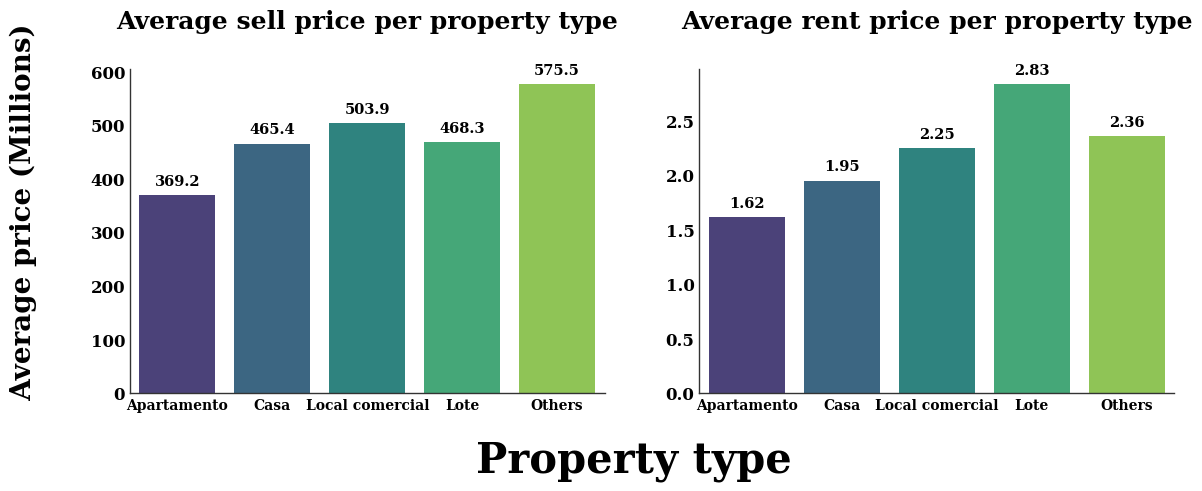

In [9]:
##Precio promedio por venta o arriendo


sell = df_gen2.loc[df_gen2['operation_type']=='Venta'].drop(columns='operation_type')
rent = df_gen2.loc[df_gen2['operation_type']=='Arriendo'].drop(columns='operation_type')

sell_price_property_type = sell.groupby('property_type')['price'].mean().reset_index().head(6)
rent_price_property_type = rent.groupby('property_type')['price'].mean().reset_index().head(6)

fig, ax = plt.subplots(figsize=(12,4),ncols=2)
fig.supxlabel('Property type',fontsize=30,y=-0.15)
fig.supylabel('  Average price (Millions)',fontsize=20,x=-0.02)

barra1 = sns.barplot(data=sell_price_property_type,x='property_type',y='price',hue='property_type',palette='viridis',ax=ax[0])
barra2 = sns.barplot(data=rent_price_property_type,x='property_type',y='price',hue='property_type',palette='viridis',ax=ax[1])

ax[0].set_xlabel('')
ax[0].set_ylabel('')
ax[0].set_title('Average sell price per property type',y=1.1,fontsize=18)
ax[0].spines[['top','right']].set_visible(False)
ax[0].tick_params(axis='y',labelsize=12)

ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[1].set_title('Average rent price per property type',y=1.1,fontsize=18)
ax[1].spines[['top','right']].set_visible(False)
ax[1].tick_params(axis='y',labelsize=12)

# for x,y in enumerate(sell_price_property_type['price']):
#     ax[0].text(x,y+20,f'{y:.0f} \nmillions',va='bottom',ha='center')

# for x,y in enumerate(rent_price_property_type['price']):
#     ax[1].text(x,y+0.05,f'{y:.2f} \nmillions',va='bottom',ha='center')

for container in barra1.containers:
    barra1.bar_label(container, padding=5,fmt='%.1f')

for container in barra2.containers:
    barra2.bar_label(container, padding=5,fmt='%.2f')
plt.show()

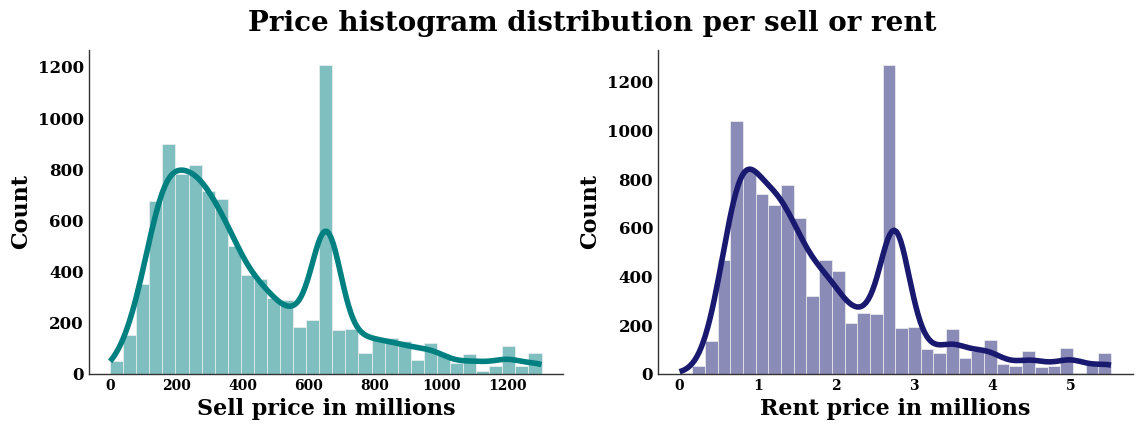

In [10]:
###Distribución de los precios separado por venta o arriendo

fig, ax = plt.subplots(ncols=2,figsize=(12,4))


fig.suptitle('Price histogram distribution per sell or rent')
sns.histplot(data=sell.sample(10000),x='price',ax=ax[0],color='teal',kde=True
)
sns.histplot(data=rent.sample(10000),x='price',ax=ax[1],color='midnightblue',kde=True
)

kind = ['Sell','Rent']
for i in range(2):
    ax[i].spines[['top','right']].set_visible(False)
    ax[i].set_xlabel(f'{kind[i]} price in millions')
    ax[i].tick_params(axis='y',labelsize=12)

plt.show()

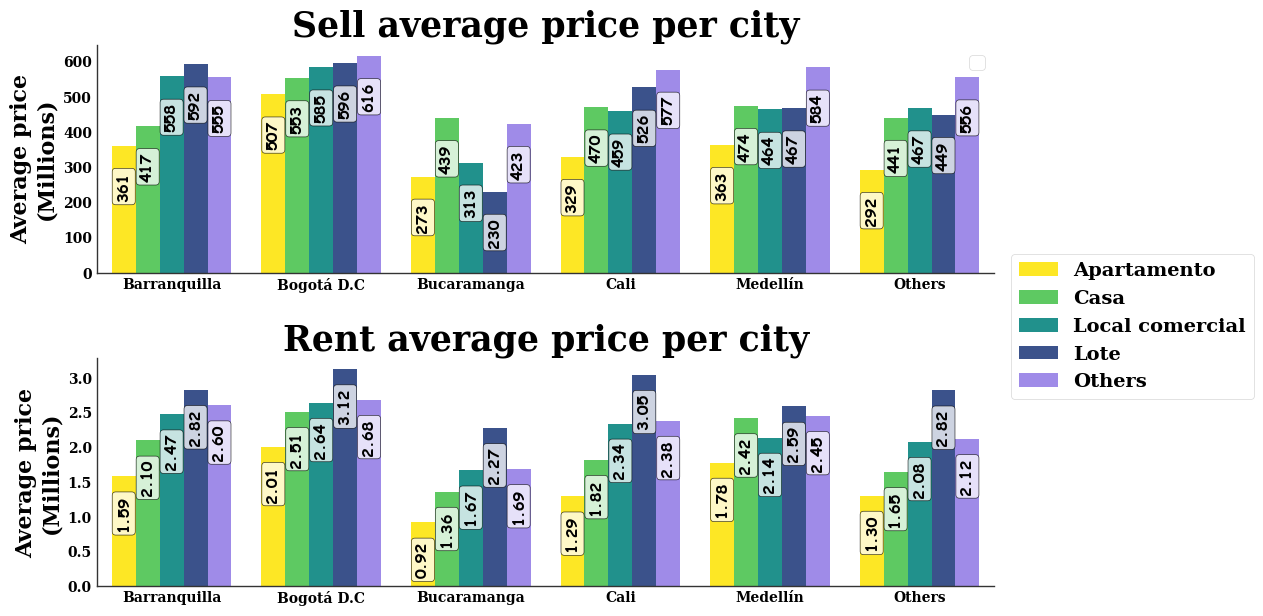

In [11]:
## Precio promedio de venta o arriendo separado por ciudad y tipo de inmueble

sell_price_city = sell.groupby(['City','property_type'])['price'].mean().reset_index()
rent_price_city = rent.groupby(['City','property_type'])['price'].mean().reset_index()

fig, ax = plt.subplots(figsize=(10,6),nrows=2)
fig.tight_layout(h_pad=4)

colors = ['#fde725','#5ec962','#21918c','#3b528b','#9f8be8']
columnas = sell_price_city['property_type'].unique()
colores = {}
for i,col in enumerate(columnas):
    colores[col] = colors[i]
barra1 = sns.barplot(data=sell_price_city,x='City',y='price',hue='property_type',palette=colores,ax=ax[0],saturation=1)
barra2 = sns.barplot(data=rent_price_city,x='City',y='price',hue='property_type',palette=colores,ax=ax[1],saturation=1)

ax[0].legend('')
ax[1].legend(bbox_to_anchor=(1.3,1.5))

for i in range(2):
    ax[i].spines[['top','right']].set_visible(False)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Average price\n(Millions)')
    ax[i].set_title(f'{kind[i]} average price per city')
    ax[i].tick_params(axis='y',labelsize=10)

for container in barra1.containers:
        barra1.bar_label(container, fmt='%.0f', label_type='edge',rotation=90,padding=-40,
                         color='k',fontsize=11.5,bbox={'facecolor':'w','pad':1,'alpha':0.75,'edgecolor':'k','boxstyle':'round,pad=0.22'},fontfamily='cursive',fontweight='bold')
        
for container in barra2.containers:
        barra2.bar_label(container, fmt='%.2f', label_type='edge',rotation=90,padding=-40,
                         color='k',fontsize=11.5,bbox={'facecolor':'w','alpha':0.75,'edgecolor':'k','boxstyle':'round,pad=0.22'},fontfamily='cursive',fontweight='bold')
        



## Análisis específico

A partir de aquí la idea es analizar un subconjunto de datos donde tenemos información del área total de cada inmueble, de la cantidad de habitaciones, entre otras variables

In [12]:
df_esp = df.dropna(subset='surface_total').drop(columns=['id','l1','created_on','ad_type','currency','title','description','price_period'])

###Obtención de la cantidad de valores nulos

missing_values(df_esp)

df_esp2 = df_esp.drop(columns=['l4','l5','l6']).reset_index(drop=True)

---------There are 3 columns with over 30% of missing values----------
start_date = 0.00%
end_date = 0.00%
lat = 5.55%
lon = 5.55%
l2 = 0.00%
l3 = 7.37%
l4 = 62.00%
l5 = 78.28%
l6 = 87.44%
rooms = 22.49%
bedrooms = 22.42%
bathrooms = 12.30%
surface_total = 0.00%
surface_covered = 5.84%
price = 0.38%
property_type = 0.00%
operation_type = 0.00%


In [13]:
## Conversión del tipo de dato

##Llenar valores nulos

numerical = df_esp2.select_dtypes('number').drop(columns=['lat','lon'])
cat = df_esp2.select_dtypes('O').drop(columns=['start_date','end_date'])

for i, col in enumerate(numerical):
    numerical[col] = numerical[col].fillna(numerical[col].mean())

for i,col in enumerate(cat):
    cat[col] = cat[col].fillna(cat[col].mode()[0])

# df_esp2 = df_esp.copy()

df_esp2[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered','price']] = numerical
df_esp2[['l2', 'l3', 'property_type', 'operation_type']] = cat

##Renombrar las columnas
df_esp2 = df_esp2.rename(columns=dict(l2='State',l3='City'))

###Convertir datos de fechas más allá de 2024

df_esp2.loc[df_esp2['end_date']>'2021-10-18','end_date'] = '2021-10-18'

##Convertir los demás datos

df_esp2['start_date'] = pd.to_datetime(df_esp2['start_date'])
df_esp2['end_date'] = pd.to_datetime(df_esp2['end_date'])

##Columna del tiempo hasta la venta
df_esp2['sold_after'] = (df_esp2['end_date'] - df_esp2['start_date']).dt.days

##Actualizar la columna del precio
df_esp2['price'] = df_esp2['price']/1000000

## Nuevos tipos
new_types = dict(
    rooms=np.int16,
    bedrooms=np.int16,
    bathrooms=np.int16,
    surface_total= np.float32,
    surface_covered = np.float32,
    price = np.float32,
    sold_after = np.int32
)

df_esp2[list(new_types.keys())] = df_esp2[new_types.keys()].astype(new_types)

df_esp2 = df_esp2.drop(columns=['start_date','end_date','lat','lon'])

### Inicia el proceso de Machine Learning

Inicialmente es es necesario convertir las variables categóricas en numéricas. Para ello vamos a ver la cantidad de valores únicos que tiene cada variable categórica

Luego vamos a ver qué variables se correlacionan entre sí.

In [14]:
def unique_ammount(df):
    cat = df.select_dtypes('O')

    for i, col in enumerate(cat):
        print(f'La columna {col} tiene --> {cat[col].nunique()} valores únicos')

unique_ammount(df_esp2)

La columna State tiene --> 24 valores únicos
La columna City tiene --> 202 valores únicos
La columna property_type tiene --> 8 valores únicos
La columna operation_type tiene --> 2 valores únicos


Las columnas categóricas tienen demasiados valores únicos. Vamos a tomar solo sus 7 primeros valores únicos con la etiqueta original y los demás les asignaremos el valor de "Other"

In [15]:
cols = ['State','City','property_type']

df_esp3 = reclass_unique_values(too_much_uniques=cols,df=df_esp2.copy(),head=6)

##Reemplazar el valor de otro por other
df_esp3['property_type'] = df_esp3['property_type'].str.replace('Otro','Others')

##Separación de inmuebles para venta y arriendo

sell = df_esp3.loc[df_esp3['operation_type']=='Venta'].drop(columns='operation_type')
rent = df_esp3.loc[df_esp3['operation_type']=='Arriendo'].drop(columns='operation_type')

# ###Convertir las variables categóricas a numéricas

columnas_dummies = sell.select_dtypes('O').columns

df_dummi = pd.get_dummies(sell,columns=columnas_dummies,drop_first=False)

corr = df_dummi.corr()

In [16]:
###Eliminar variables para optimizar el código

del [ax,barra1,barra2,cat,col,colores,colors,cols,columnas,columnas_dummies,container,
     delete_columns,df, df_esp,df_esp2,df_esp3,df_gen,df_gen2,fig,filling_dictionary,i,iqr_rent,iqr_sell,kind,
     rent_price_city,sell_price_city,sell_price_property_type,rent_price_property_type,too_much_uniques]

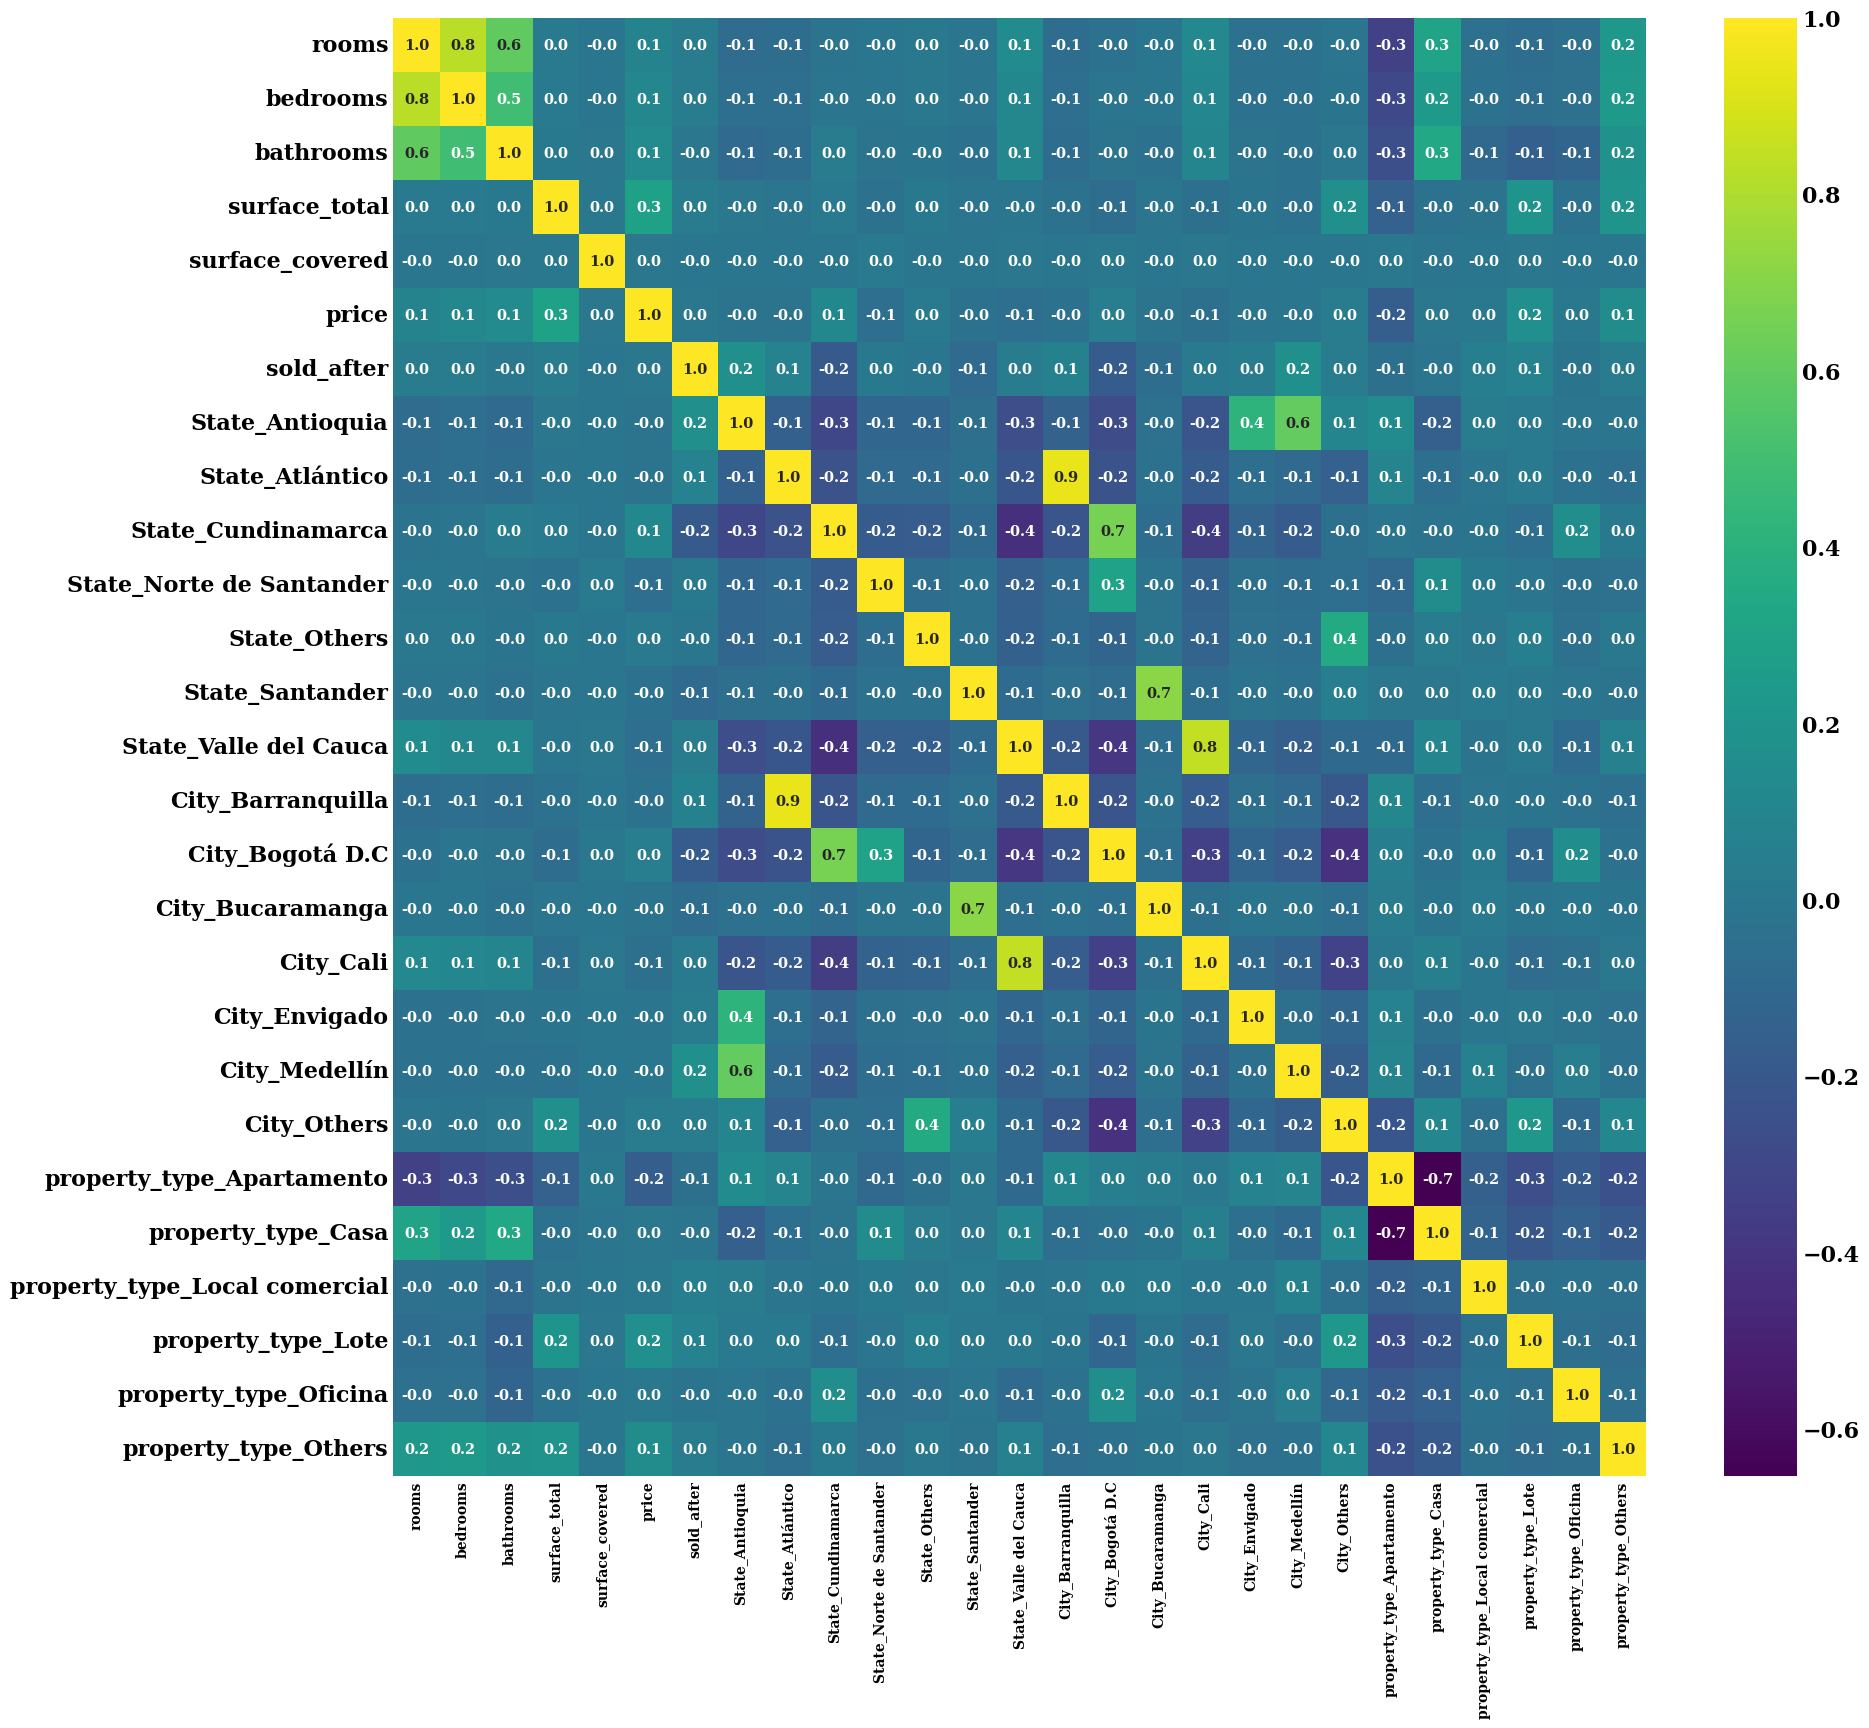

In [17]:
fig, ax = plt.subplots(figsize=(18,18))
sns.heatmap(corr,annot=True,cmap='viridis',fmt='.1f')
plt.show()

### Problema a resolver: Encontrar el modelo que predice mejor el precio del inmueble a partir de las demás features

In [18]:

x = df_dummi.drop(columns='price')
y = df_dummi['price']

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso, ElasticNet, LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures

grado = 2
pol_reg = PolynomialFeatures(degree=grado)

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=123)
x_train_pol = pol_reg.fit_transform(x_train)
x_test_pol = pol_reg.fit_transform(x_test)

modelos = dict(
Linear_Regression = LinearRegression(),
Ridge = Ridge(),
Lasso = Lasso(),
Tree = DecisionTreeRegressor(random_state=123),
Random_Forest = RandomForestRegressor(random_state=123),
Elastic = ElasticNet(),
SVR = SVR(),
Polynomial = LinearRegression()
)

def evaluar_modelos(modelos=modelos):
    best_model = None
    best_score = 0
    for name, model in modelos.items():
        mse = 0
        r2 = 0
        if name!='Polynomial':
            y_pred = model.fit(x_train,y_train).predict(x_test)
        else:
            y_pred = model.fit(x_train_pol,y_train).predict(x_test_pol)
    ##Obtener el redimiento
        mse = mean_squared_error(y_test,y_pred)
        r2 = r2_score(y_test,y_pred)
        print(f'El rendimiento del modelo {name} es:\nMSE:{mse:.3f} -- R2:{r2:.3f}\n')

        if r2>best_score:
            best_score = r2
            best_model = model
        else:
            best_score = best_score
            best_model = best_model
    print(f'El mejor modelo es {best_model} con un R2 de {best_score:.4f}')
    return best_model

model = evaluar_modelos()

El rendimiento del modelo Linear_Regression es:
MSE:9059575.383 -- R2:0.154

El rendimiento del modelo Ridge es:
MSE:9059552.322 -- R2:0.154

El rendimiento del modelo Lasso es:
MSE:9059225.406 -- R2:0.154

El rendimiento del modelo Tree es:
MSE:6455200.555 -- R2:0.397

El rendimiento del modelo Random_Forest es:
MSE:6025755.484 -- R2:0.437

El rendimiento del modelo Elastic es:
MSE:9242547.276 -- R2:0.137

El rendimiento del modelo SVR es:
MSE:11008991.648 -- R2:-0.028

El rendimiento del modelo Polynomial es:
MSE:7736261.387 -- R2:0.278

El mejor modelo es RandomForestRegressor(random_state=123) con un R2 de 0.4374


### Resultado de los modelos

Random Forest es el modelo que mejor se acomoda a los datos. Vamos a hacer ajuste de hiperparámetros para mejorar el rendimiento

In [64]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

parametros_tree = dict(
    criterion = ['squared_error','absolute_error'],
    splitter = ['best','random'],
    max_depth = [7,9],
    min_samples_split = [6,7],
    min_samples_leaf = [6,7],
)

parametros_forest = {
 'max_depth': np.arange(10,20,1),
 'max_features': ['sqrt','log',None],
 'max_leaf_nodes': np.arange(0,2000,500),
#  'min_samples_leaf': [4,6,8],
#  'min_samples_split': [4,6,8],
 'n_estimators': np.arange(100,200,20),
#  'n_jobs': None,
#  'oob_score': False,
#  'random_state': 123,
#  'verbose': 0,
#  'warm_start': [False,True]
 }

def mejores_parametros(modelo, parametros,nombre):
    grid = GridSearchCV(estimator=modelo, cv=3,verbose=2,param_grid=parametros,n_jobs=-1)
    grid.fit(x_train,y_train)
    print(f'\nEl puntaje del modelo {nombre} es {grid.best_score_:.4f}')
    print(f'\nMejores parámetros: {grid.best_params_}')

    return grid.best_estimator_

model = mejores_parametros(RandomForestRegressor(random_state=123),parametros_forest,'Random Forest')
# model = mejores_parametros(RandomForestRegressor(random_state=123,max_features='sqrt',n_estimators=160,max_depth=16,
#                                                  max_leaf_nodes=1000),parametros_forest,'Random Forest')


Fitting 3 folds for each of 600 candidates, totalling 1800 fits


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
900 fits failed out of a total of 1800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py


El puntaje del modelo Random Forest es 0.3439

Mejores parámetros: {'max_depth': 17, 'max_features': 'sqrt', 'max_leaf_nodes': 1500, 'n_estimators': 180}


In [70]:
y_pred = model.fit(x_train,y_train).predict(x_test)

r2 = r2_score(y_test,y_pred)
r2

0.44313287323934347